In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import albumentations as A
import cv2

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(12, 6)
plt.rcParams['font.size']=10

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [2]:
# Initial configurations
DATASET_PATH='../../data/food-101/food-101'
OUTPUT_PATH='../../data/food-101/food-101-processed'

TARGET_SIZE=(224, 224)

TRAIN_RATIO=0.7
VAL_RATIO=0.15
TEST_RATIO=0.15

dataset_path=Path(DATASET_PATH)
images_path=dataset_path/'images'
meta_path=dataset_path/'meta'

Sampling classes: 100%|██████████| 20/20 [00:00<00:00, 20.53it/s]


Image statistics (sample of 100)
Width: 
Max: 512 | Min: 289 | Mean: 481.79
Height: 
Max: 512 | Min: 288 | Mean: 477.56


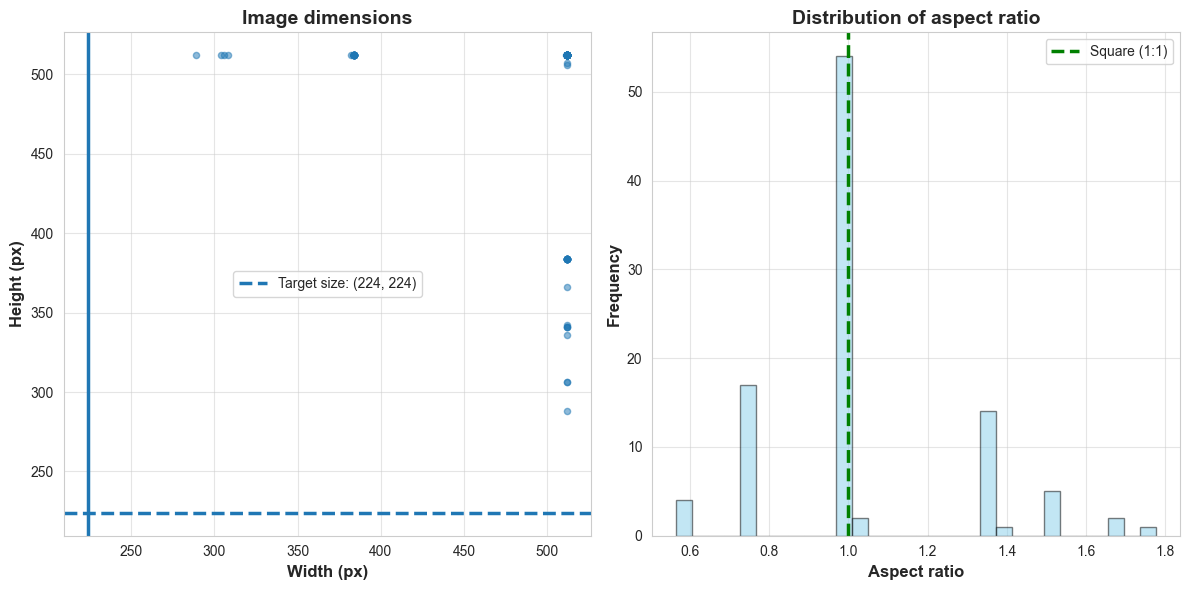

In [3]:
class_folders=sorted([d for d in images_path.iterdir() if d.is_dir()])
dimensions=[]
aspect_ratio=[]

for class_folder in tqdm.tqdm(class_folders[:20], desc='Sampling classes'):
    images=list(class_folder.glob('*jpg'))[:5]
    
    for img_path in images:
        try: 
            with Image.open(img_path) as img: 
                width, height=img.size
                dimensions.append((width, height))
                aspect_ratio.append(width / height)
        except:
            pass

widths=[d[0] for d in dimensions]
heights=[d[1] for d in dimensions]

print(f'Image statistics (sample of {len(dimensions)})')
print(f'Width: \nMax: {max(widths)} | Min: {min(widths)} | Mean: {np.mean(widths):.2f}')
print(f'Height: \nMax: {max(heights)} | Min: {min(heights)} | Mean: {np.mean(heights):.2f}')

# Viz
fig, ax=plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(widths, heights, alpha=0.5, s=20)
ax[0].axhline(TARGET_SIZE[0], linestyle='--', linewidth=2.5, label=f'Target size: {TARGET_SIZE}')
ax[0].axvline(TARGET_SIZE[1], linestyle='-', linewidth=2.5)
ax[0].set_xlabel('Width (px)', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Height (px)', fontsize=12, fontweight='bold')
ax[0].set_title('Image dimensions', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].hist(aspect_ratio, bins=30, color='skyblue', edgecolor='black', alpha=0.5)
ax[1].axvline(1, color='green', linestyle='--', linewidth=2.5, label='Square (1:1)') 
ax[1].set_xlabel('Aspect ratio', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax[1].set_title('Distribution of aspect ratio', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# plt.savefig('figures/image_stats.png', dpi=300, bbox_inches='tight')

Sample image: apple_pie/1005649.jpg


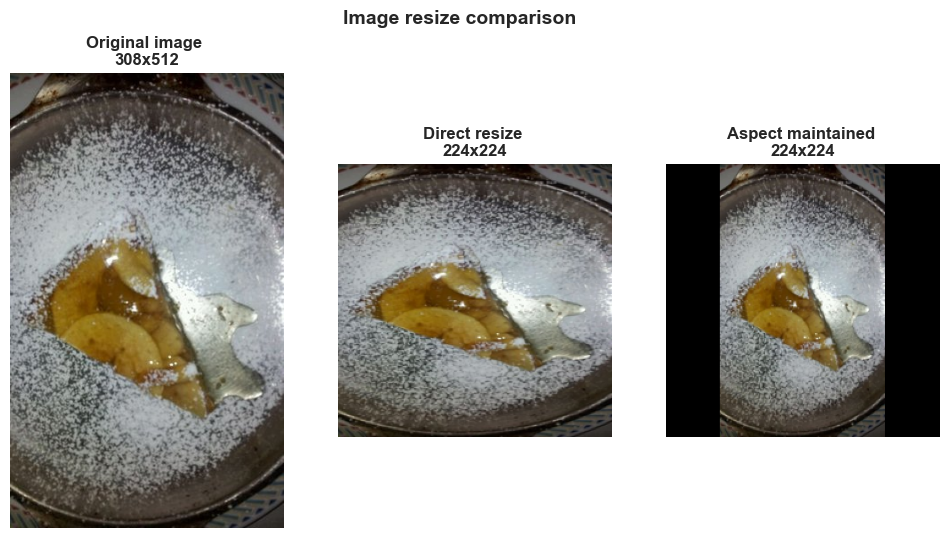

In [5]:
# Resize Img
def resize_image(image_path, target_size=(224, 224), maintain_aspect=False):
    img=Image.open(image_path).convert('RGB')
    
    if maintain_aspect: 
        img.thumbnail(target_size, Image.Resampling.LANCZOS)

        new_img=Image.new('RGB', target_size, (0, 0, 0))
        paste_x=(target_size[0] - img.size[0]) // 2
        paste_y=(target_size[1] - img.size[1]) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img 
    else: 
        return img.resize(target_size, Image.Resampling.LANCZOS)
    
class_folders=sorted([d for d in images_path.iterdir() if d.is_dir()])
sample_img=list(class_folders[0].glob('*.jpg'))[0]

print(f'Sample image: {sample_img.parent.name}/{sample_img.name}')

# Comparison
fig, ax=plt.subplots(1, 3, figsize=(12, 6))

with Image.open(sample_img) as img:
    ax[0].imshow(img)
    ax[0].set_title(f'Original image \n{img.size[0]}x{img.size[1]}', fontweight='bold')
    ax[0].axis('off')

direct_resize=resize_image(sample_img, TARGET_SIZE, maintain_aspect=False)
ax[1].imshow(direct_resize)
ax[1].set_title(f'Direct resize \n{direct_resize.size[0]}x{direct_resize.size[1]}', fontweight='bold')
ax[1].axis('off')

aspect_maintained=resize_image(sample_img, TARGET_SIZE, maintain_aspect=True)
ax[2].imshow(aspect_maintained)
ax[2].set_title(f'Aspect maintained \n{aspect_maintained.size[0]}x{aspect_maintained.size[1]}', fontweight='bold')
ax[2].axis('off')

plt.suptitle(f'Image resize comparison', fontsize=14, fontweight='bold')
plt.savefig('figures/image_resize_comparison', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_37780\3735867295.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),


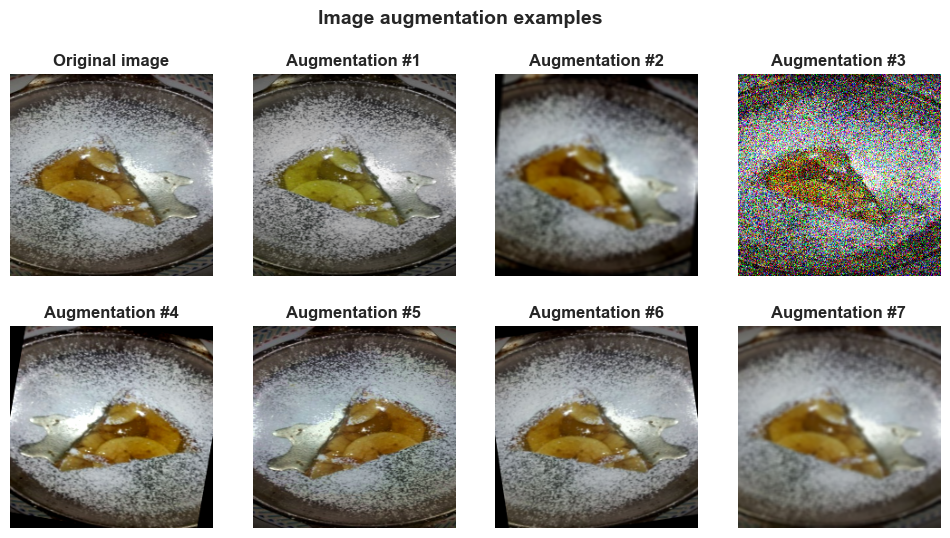

In [32]:
# Data augmentation
train_augmentation=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.Affine(translate_percent={'x':0.1, 'y':0.1}, scale=(0.9, 1.1), rotate=(+15, -15), p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

    A.GaussNoise(var_limit=(10, 30), p=0.3),
    # A.GaussNoise(std_range=(0.01, 0.05), p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_augmentation=A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_augmentation(image_path, augmentation, num_samples=5):
    img=np.array(Image.open(image_path).convert('RGB'))
    img=cv2.resize(img, TARGET_SIZE)

    augmented_img=[]
    for _ in range(num_samples):
        augmented=augmentation(image=img)['image']

        augmented_vis=augmented * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        augmented_vis=np.clip(augmented_vis, 0, 1)
        augmented_img.append(augmented_vis)

    return img, augmented_img

# Comparison
original, augmented_samples=apply_augmentation(sample_img, train_augmentation, num_samples=7)

fig, ax=plt.subplots(2, 4,  figsize=(12, 6))
ax=ax.flatten()

ax[0].imshow(original)
ax[0].set_title(f'Original image', fontweight='bold')
ax[0].axis('off')

for i, aug_img in enumerate(augmented_samples[:7], 1):
    ax[i].imshow(aug_img)
    ax[i].set_title(f'Augmentation #{i}', fontweight='bold')
    ax[i].axis('off')

plt.suptitle('Image augmentation examples', fontsize=14, fontweight='bold')
plt.savefig('figures/image_augmentation_examples', dpi=300, bbox_inches='tight')
plt.show()

In [129]:
# Data splitting
all_data=[]
for class_folder in tqdm.tqdm(class_folders, desc='Processing classes'):
    class_name=class_folder.name
    images=list(class_folder.glob('*.jpg')) + \
        list(class_folder.glob('*.png')) + \
        list(class_folder.glob('*.jpeg'))
    
    for img_path in images:
        all_data.append({ 
            'image_path': str(img_path),
            'class_name': class_name,
            'relative_path': f'{class_name}/{img_path.name}'
        })

df=pd.DataFrame(all_data)

train_df, temp_df=train_test_split(
    df, 
    test_size=(VAL_RATIO + TEST_RATIO),
    stratify=df['class_name'],
    random_state=RANDOM_SEED
)

val_df, test_df=train_test_split(
    temp_df,
    test_size=0.5, 
    stratify=temp_df['class_name'],
    random_state=RANDOM_SEED
)

sample_cls=df['class_name'].unique()[:5]

# Verification of stratification
verification_data=[]
for cls in sample_cls:
    train_count=len(train_df[train_df['class_name'] == cls])
    val_count=len(val_df[val_df['class_name'] == cls])
    test_count=len(test_df[test_df['class_name'] == cls])
    total=train_count + val_count + test_count

    verification_data.append({
        'class': cls,
        'train': train_count, 
        'validation': val_count,
        'test': test_count,
        'total': total,
        'train %': f'{train_count/total*100:.0f}%'
    })

verification_df=pd.DataFrame(verification_data)

Processing classes: 100%|██████████| 101/101 [00:00<00:00, 196.16it/s]


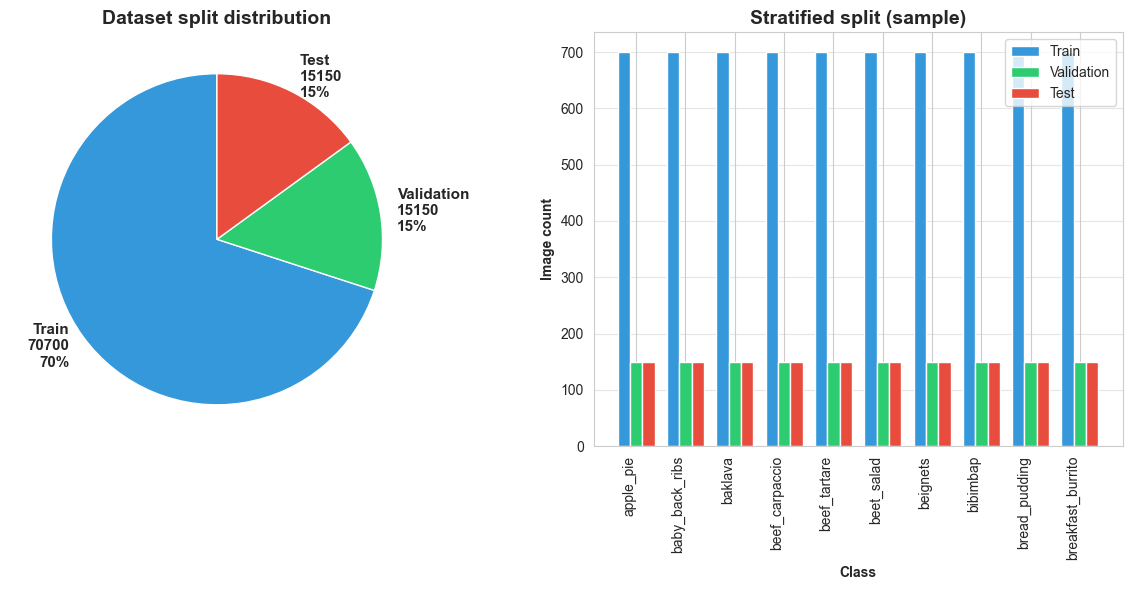

In [133]:
# Split distribution viz
fig, ax=plt.subplots(1, 2, figsize=(12, 6))

split_counts=[len(train_df), len(val_df), len(test_df)]
split_labels=[f'Train\n{len(train_df)}\n{len(train_df)/len(df)*100:.0f}%',
              f'Validation\n{len(val_df)}\n{len(val_df)/len(df)*100:.0f}%',
              f'Test\n{len(test_df)}\n{len(test_df)/len(df)*100:.0f}%']
colors = ['#3498db', '#2ecc71', '#e74c3c']

ax[0].pie(split_counts, labels=split_labels, colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax[0].set_title(f'Dataset split distribution', fontsize=14, fontweight='bold')

sample_classes_viz = df['class_name'].unique()[:10]
train_counts = [len(train_df[train_df['class_name'] == cls]) for cls in sample_classes_viz]
val_counts = [len(val_df[val_df['class_name'] == cls]) for cls in sample_classes_viz]
test_counts = [len(test_df[test_df['class_name'] == cls]) for cls in sample_classes_viz]

x = np.arange(len(sample_classes_viz))
width = 0.25

ax[1].bar(x - width, train_counts, width, label='Train', color='#3498db')
ax[1].bar(x, val_counts, width, label='Validation', color='#2ecc71')
ax[1].bar(x + width, test_counts, width, label='Test', color='#e74c3c')

ax[1].set_xlabel('Class', fontweight='bold')
ax[1].set_ylabel('Image count', fontweight='bold')
ax[1].set_title('Stratified split (sample)', fontweight='bold', fontsize=14)
ax[1].set_xticks(x)
ax[1].set_xticklabels(sample_classes_viz, rotation=90, ha='right')
ax[1].legend()
ax[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.savefig('figures/stratified_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()